In [1]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
#import proplot as plot
from windrose import WindroseAxes
import windrose
from glob import glob
import matplotlib.cm as cm
from metpy.calc import wind_direction
from wrf import (to_np, getvar,get_cartopy, cartopy_xlim,GeoBounds,CoordPair,
                 cartopy_ylim, latlon_coords)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib.gridspec import GridSpec

/var/folders/qp/gxgdxp1n1qlbthfw1g5p3pvh0000gp/T/ipykernel_48888/1187586505.py:17: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
file_ref = 'wrfout_d01_2020-08-01_00:00:00'
reg_coords = {'BAL':[38.6,0.9,40.3,4.7],
              'MAL':[39.2,2.25,40.1,3.6]}
reg = 'MAL'

In [3]:
def get_geoinfo():

    fileref = nc.Dataset(f'./{file_ref}')
    hgt = getvar(fileref, "ter")
    lats, lons = latlon_coords(hgt)
    cart_proj = get_cartopy(hgt)

    return cart_proj,lats,lons,hgt

def new_axes():
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax


In [4]:
cart_proj,lats,lons,hgt = get_geoinfo()

mbounds = GeoBounds(CoordPair(lat=reg_coords[reg][0], lon=reg_coords[reg][1]),
                       CoordPair(lat=reg_coords[reg][2], lon=reg_coords[reg][3]))


In [5]:
filesinu = sorted(glob(f'./BAL/UIB_01H_U10MET_20*.nc'))
filesinv = sorted(glob(f'./BAL/UIB_01H_V10MET_20*.nc'))

In [6]:
fin_u = xr.open_mfdataset(filesinu,concat_dim="time", combine="nested")
fin_v = xr.open_mfdataset(filesinv,concat_dim="time", combine="nested")

In [7]:
fin_u.coords['y']=fin_u.lat.values[0,:,0]
fin_u.coords['x']=fin_u.lon.values[0,0,:]

fin_v.coords['y']=fin_v.lat.values[0,:,0]
fin_v.coords['x']=fin_v.lon.values[0,0,:]

In [8]:
fin_uv = (fin_u.U10MET**2 + fin_v.V10MET**2)**0.5
fin_dir = (270 - np.arctan2(fin_v.V10MET, fin_u.U10MET) * 180 / np.pi) % 360


# fin_dir = np.arctan2(fin_v.V10MET, fin_u.U10MET) * 180 / np.pi
# fin_dir = 90 - fin_dir
# fin_dir = fin_dir.where(fin_dir>0,fin_dir+360.)

In [9]:
fin_uv_hour = fin_uv.groupby(fin_uv.time.dt.hour).mean()



In [ ]:
fig = plt.figure(figsize=(10, 25))



for nh,hour in enumerate(range(10,19)):
    ax = fig.add_subplot(5,2,nh+1,projection=cart_proj)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
    ax.add_feature(cfeature.BORDERS,linewidth=0.5)
    ax.text(0.5,1.02,f"{hour}H", fontsize='x-large', horizontalalignment='center', transform=ax.transAxes)
    m0=ax.contourf(to_np(fin_u.lon.isel(time=0).squeeze()), to_np(fin_u.lat.isel(time=0).squeeze()), fin_uv_hour.sel(hour=hour),
                 transform=ccrs.PlateCarree(),
                 cmap='magma',extend='both',levels=np.arange(0,7,0.5))
   
    ax.set_xlim(cartopy_xlim(hgt,geobounds=mbounds))
    ax.set_ylim(cartopy_ylim(hgt,geobounds=mbounds))
    

    gl=ax.gridlines(crs=ccrs.PlateCarree(), xlocs=np.arange(2,4,0.5), ylocs=np.arange(39,41,0.5),
                 draw_labels=True, zorder=101,
                 linewidth=0.2, color='k', alpha=1, linestyle='--')

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER


cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cb1=plt.colorbar(m0, cax=cbar_ax,orientation="horizontal")
cb1.set_label('m/s)')
# fig.colorbar(m0,length=0.7, loc='b',label='m/s')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 25))
ax0 = fig.add_subplot(2,1,1,projection=cart_proj)

ax0.set_xlim(cartopy_xlim(hgt,geobounds=mbounds))
ax0.set_ylim(cartopy_ylim(hgt,geobounds=mbounds))
ax0.add_feature(cfeature.OCEAN, zorder=100,facecolor=[24/255,  116/255,  205/255])
ax0.add_feature(cfeature.LAND, zorder=100, edgecolor=None,facecolor='gray')
ax0.add_feature(cfeature.COASTLINE,zorder=101,linewidth=0.5)

ax0.scatter(x=3.3, y=39.4, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
#ax0.scatter(2.5,39.8,s=10,c='r',transform=ccrs.PlateCarree())

# ax1 = fig.add_subplot(2, 1, 2, projection="windrose", rmax = 50)

# #ax1 = fig.add_subplot(2,1,2)
# #ax1 = WindroseAxes.from_ax()
# ax1.bar(fin_dir.sel(x=2.5,y=39.8,method="nearest").values,fin_uv.sel(x=2.5,y=39.8,method="nearest").values, normed=True, opening=0.8, edgecolor='white',cmap=cm.viridis)
# ax1.set_legend()


In [ ]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(4, 3,  width_ratios=(1,1,1), height_ratios=(1, 1, 1, 1),
                      wspace=0.2, hspace=0.2)
shour = 10
ehour = 18

loc_lat = {'1': 40,'2': 39.8,'3':39.6,'4':39.42,'5':39.35,'6':39.90,'7':39.8,'8':39.60,'9':39.4,'10':39.2}
loc_lon = {'1':  3,'2':  2.5,'3': 2.3,'4':  2.5,'5': 2.90,'6': 3.25,'7': 3.4,'8': 3.45,'9': 3.3,'10': 3.1}

fin_dir_h = fin_dir.where((fin_dir.time.dt.hour>=shour) & (fin_dir.time.dt.hour<=ehour),drop=True)
fin_spd_h = fin_uv.where((fin_uv.time.dt.hour>=shour) & (fin_uv.time.dt.hour<=ehour),drop=True)

## MAP CENTRAL
ax = fig.add_subplot(gs[1:3,1],projection=cart_proj)
#ax = fig.add_subplot(5,2,nh+1,projection=cart_proj)
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.BORDERS,linewidth=0.5)
ax.text(0.5,1.02,f"{hour}H", fontsize='x-large', horizontalalignment='center', transform=ax.transAxes)
m0=ax.contourf(to_np(fin_u.lon.isel(time=0).squeeze()), to_np(fin_u.lat.isel(time=0).squeeze()), fin_spd_h.mean(dim='time'),
                 transform=ccrs.PlateCarree(),
                 cmap='viridis',extend='both',levels=np.arange(0,12,2))

ax.set_xlim(cartopy_xlim(hgt,geobounds=mbounds))
ax.set_ylim(cartopy_ylim(hgt,geobounds=mbounds))
plt.colorbar(m0,shrink=0.3, orientation='horizontal',label='m/s')



## WINDROSES


ax.scatter(x=3, y=40, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax.text(3.02, 40.02,'1',fontsize='x-large',color='k',horizontalalignment='center',zorder=101,transform=ccrs.PlateCarree())
ax1.text(0.1,1.02,'1', fontsize='x-large', horizontalalignment='left', transform=ax.transAxes)
ax1 = fig.add_subplot(gs[0,1], projection="windrose", rmax = 25)
ax1.bar(fin_dir_h.sel(x=3, y=40,method="nearest").values,fin_spd_h.sel(x=3, y=40,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax1.set_legend()

ax.scatter(x=2.5, y=39.8, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax.text(2.52, 39.82,'2',fontsize='x-large',color='k',horizontalalignment='center',zorder=101,transform=ccrs.PlateCarree())
ax2.text(0.1,1.02,'2', fontsize='x-large', horizontalalignment='left', transform=ax.transAxes)
ax2 = fig.add_subplot(gs[0,0], projection="windrose", rmax = 25)
ax2.bar(fin_dir_h.sel(x=2.5,y=39.8,method="nearest").values,fin_spd_h.sel(x=2.5,y=39.8,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax2.set_legend()

ax.scatter(x=2.3, y=39.6, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1,0], projection="windrose", rmax = 25)
ax3.bar(fin_dir_h.sel(x=2.3, y=39.6,method="nearest").values,fin_spd_h.sel(x=2.3, y=39.6,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax1.set_legend()



ax.scatter(x=2.5, y=39.42, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[2,0], projection="windrose", rmax = 25)
ax4.bar(fin_dir_h.sel(x=2.5, y=39.42,method="nearest").values,fin_spd_h.sel(x=2.5, y=39.42,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()

ax.scatter(x=2.9, y=39.35, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[3,0], projection="windrose", rmax = 25)
ax5.bar(fin_dir_h.sel(x=2.9, y=39.35,method="nearest").values,fin_spd_h.sel(x=2.9, y=39.35,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()

ax.scatter(x=3.25, y=39.9, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[0,2], projection="windrose", rmax = 25)
ax6.bar(fin_dir_h.sel(x=3.25, y=39.9,method="nearest").values,fin_spd_h.sel(x=3.25, y=39.9,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()

ax.scatter(x=3.4, y=39.8, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax7 = fig.add_subplot(gs[1,2], projection="windrose", rmax = 25)
ax7.bar(fin_dir_h.sel(x=3.4, y=39.8,method="nearest").values,fin_spd_h.sel(x=3.4, y=39.8,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()

ax.scatter(x=3.45, y=39.6, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax8 = fig.add_subplot(gs[2,2], projection="windrose", rmax = 25)
ax8.bar(fin_dir_h.sel(x=3.45, y=39.6,method="nearest").values,fin_spd_h.sel(x=3.45, y=39.6,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()

ax.scatter(x=3.3, y=39.4, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax9 = fig.add_subplot(gs[3,2], projection="windrose", rmax = 25)
ax9.bar(fin_dir_h.sel(x=3.3, y=39.4,method="nearest").values,fin_spd_h.sel(x=3.3, y=39.4,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()

ax.scatter(x=3.1, y=39, s=100, c='r',zorder=101,transform=ccrs.PlateCarree())
ax10 = fig.add_subplot(gs[3,1], projection="windrose", rmax = 25)
ax10.bar(fin_dir_h.sel(x=3.1, y=39,method="nearest").values,fin_spd_h.sel(x=3.1, y=39,method="nearest").values, normed=True,bins=np.arange(0,12,2), opening=0.8, edgecolor='white',cmap=cm.viridis)
#ax4.set_legend()


plt.show()

In [ ]:
# ax1 = WindroseAxes.from_ax()
# ax1.bar(fin_dir_h.sel(x=2.5,y=39.8,method="nearest").values,fin_spd_h.sel(x=2.5,y=39.8,method="nearest").values, normed=True, opening=0.8, edgecolor='white',cmap=cm.viridis)
# ax1.set_legend()

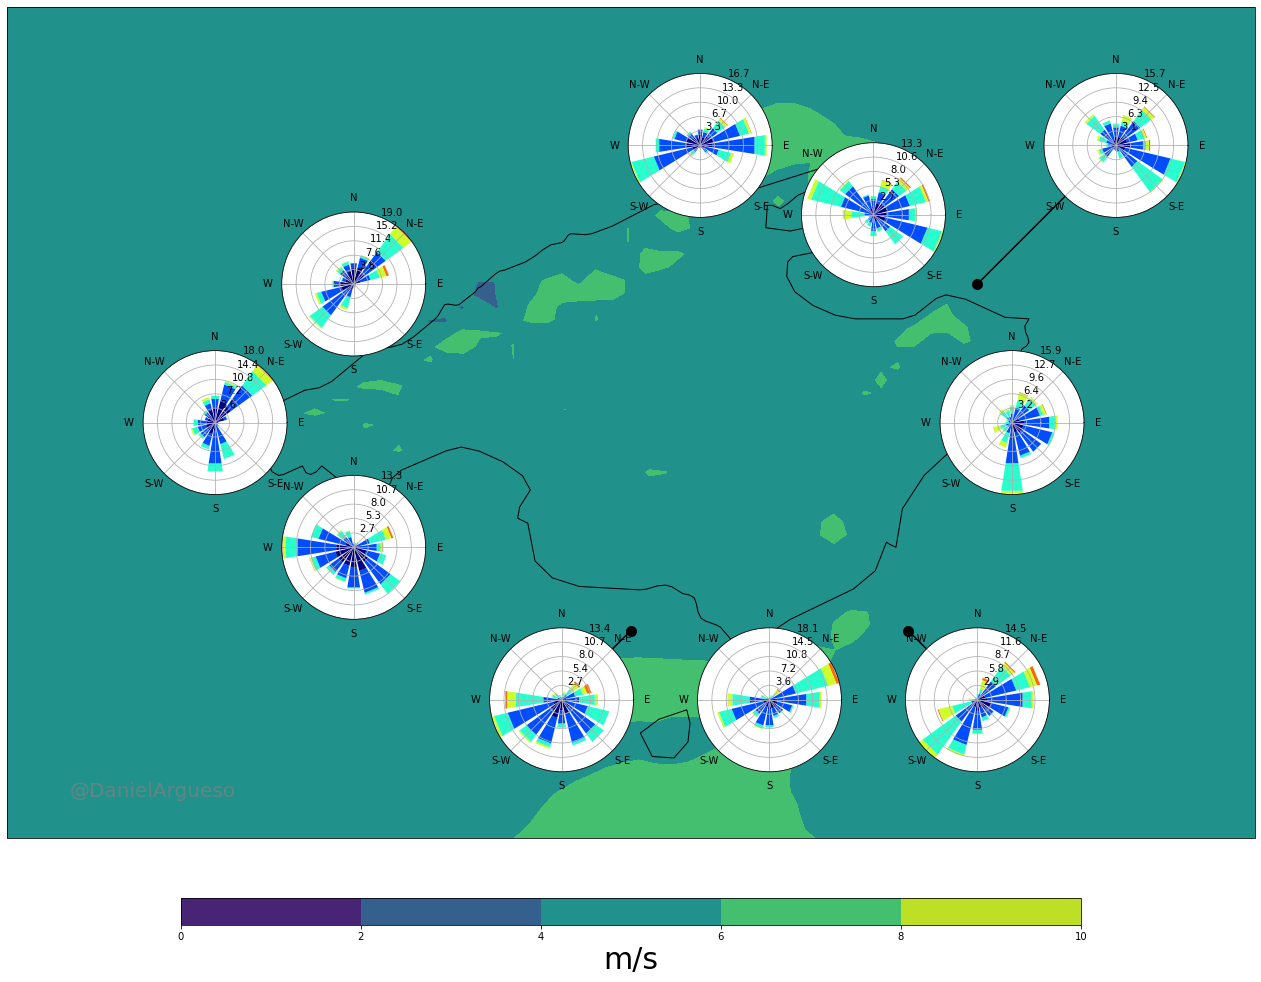

In [10]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()



loc_lat = {'1': 40,'2': 39.8,'3':39.6,'4':39.42,'5':39.3,'6':39.90,'7':39.8,'8':39.60,'9':39.3,'10':39.2}
loc_lon = {'1':  3,'2':  2.5,'3': 2.3,'4':  2.5,'5': 2.90,'6': 3.25,'7': 3.4,'8': 3.45,'9': 3.3,'10': 3.1}



shour = 8
ehour = 16

fin_dir_h = fin_dir.where((fin_dir.time.dt.hour>=shour) & (fin_dir.time.dt.hour<=ehour),drop=True)
fin_spd_h = fin_uv.where((fin_uv.time.dt.hour>=shour) & (fin_uv.time.dt.hour<=ehour),drop=True)

m0=ax.contourf(to_np(fin_u.lon.isel(time=0).squeeze()), to_np(fin_u.lat.isel(time=0).squeeze()), fin_spd_h.mean(dim='time'),
                 transform=ccrs.PlateCarree(),
                 cmap='viridis',levels=np.arange(0,12,2))

# plt.colorbar(m0,shrink=0.5, orientation='horizontal',location='bottom',label='m/s')



ax.set_extent([2,3.8,39,40.2],crs=ccrs.PlateCarree())
ax.text(0.05,0.05,'@DanielArgueso', fontsize='20', horizontalalignment='left', transform=ax.transAxes,c='gray',alpha=0.7)



for loc in loc_lon.keys():
    

    lon,lat = loc_lon[loc],loc_lat[loc]
    
    if loc =='5':
        lon,lat = loc_lon[loc]-0.1,loc_lat[loc]-0.1
        ax.scatter(x=loc_lon[loc], y=loc_lat[loc], s=100, c='k',zorder=101,transform=ccrs.PlateCarree())
        ax.plot(np.asarray([loc_lon[loc],loc_lon[loc]-0.1]),np.asarray([loc_lat[loc],loc_lat[loc]-0.1]), c='k',zorder=101,transform=ccrs.PlateCarree())

    if loc =='7':
        lon,lat = loc_lon[loc]+0.2,loc_lat[loc]+0.2
        ax.scatter(x=loc_lon[loc], y=loc_lat[loc], s=100, c='k',zorder=101,transform=ccrs.PlateCarree())
        ax.plot(np.asarray([loc_lon[loc],loc_lon[loc]+0.2]),np.asarray([loc_lat[loc],loc_lat[loc]+0.2]), c='k',zorder=101,transform=ccrs.PlateCarree())
    
    if loc =='9':
        lon,lat = loc_lon[loc]+0.1,loc_lat[loc]-0.1
        ax.scatter(x=loc_lon[loc], y=loc_lat[loc], s=100, c='k',zorder=101,transform=ccrs.PlateCarree())
        ax.plot(np.asarray([loc_lon[loc],loc_lon[loc]+0.1]),np.asarray([loc_lat[loc],loc_lat[loc]-0.1]), c='k',zorder=101,transform=ccrs.PlateCarree())

    
    lonr,latr =  ccrs.PlateCarree().transform_point(lon,lat, ccrs.PlateCarree())

    wrax_passy = inset_axes(ax,
            width=2,                        # size in % of bbox
            height=2,                       # size in % of bbox
            loc='center',  # don't know why, but this doesn't work.
            # specify the center lon and lat of the plot, and size in degree
            bbox_to_anchor=(lonr,latr),
            bbox_transform=ax.transData,
            axes_class=windrose.WindroseAxes,
            )
    wrax_passy.bar(fin_dir_h.sel(x=loc_lon[f'{loc}'], y=loc_lat[f'{loc}'],method="nearest").values,fin_spd_h.sel(x=loc_lon[f'{loc}'], y=loc_lat[f'{loc}'],method="nearest").values,normed=True)


cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cbar=plt.colorbar(m0, cax=cbar_ax,orientation="horizontal")
cbar.set_label ('m/s',fontsize='30')
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.18,wspace=0.05,hspace=0.05)
plt.savefig('Mallorca_Wind_April.png',dpi=300)

In [ ]:
print(f"{1:03}")

10H
11H
12H
13H
14H
15H
16H
17H
18H


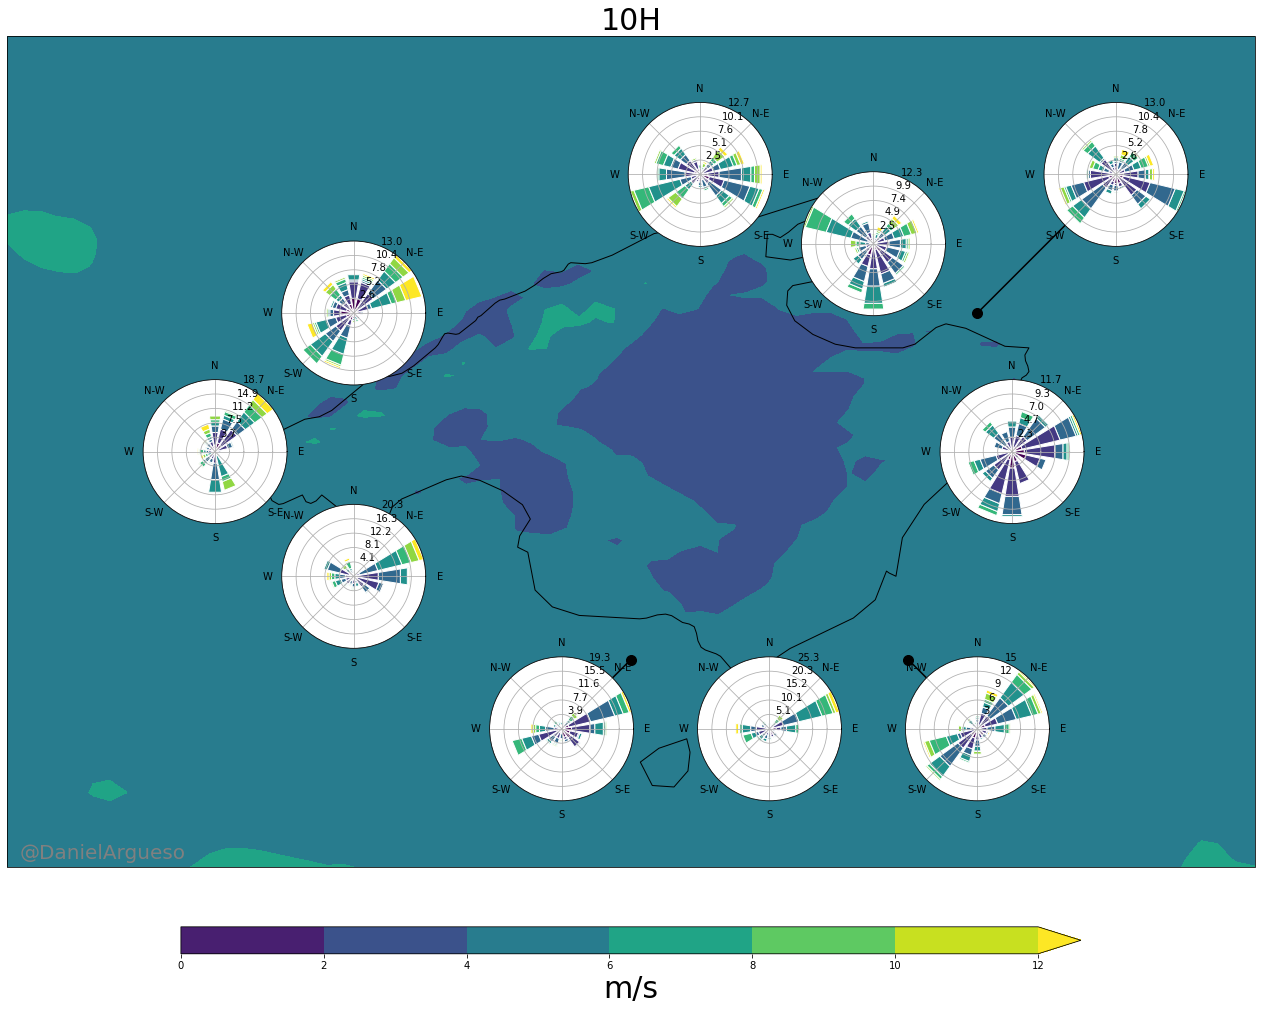

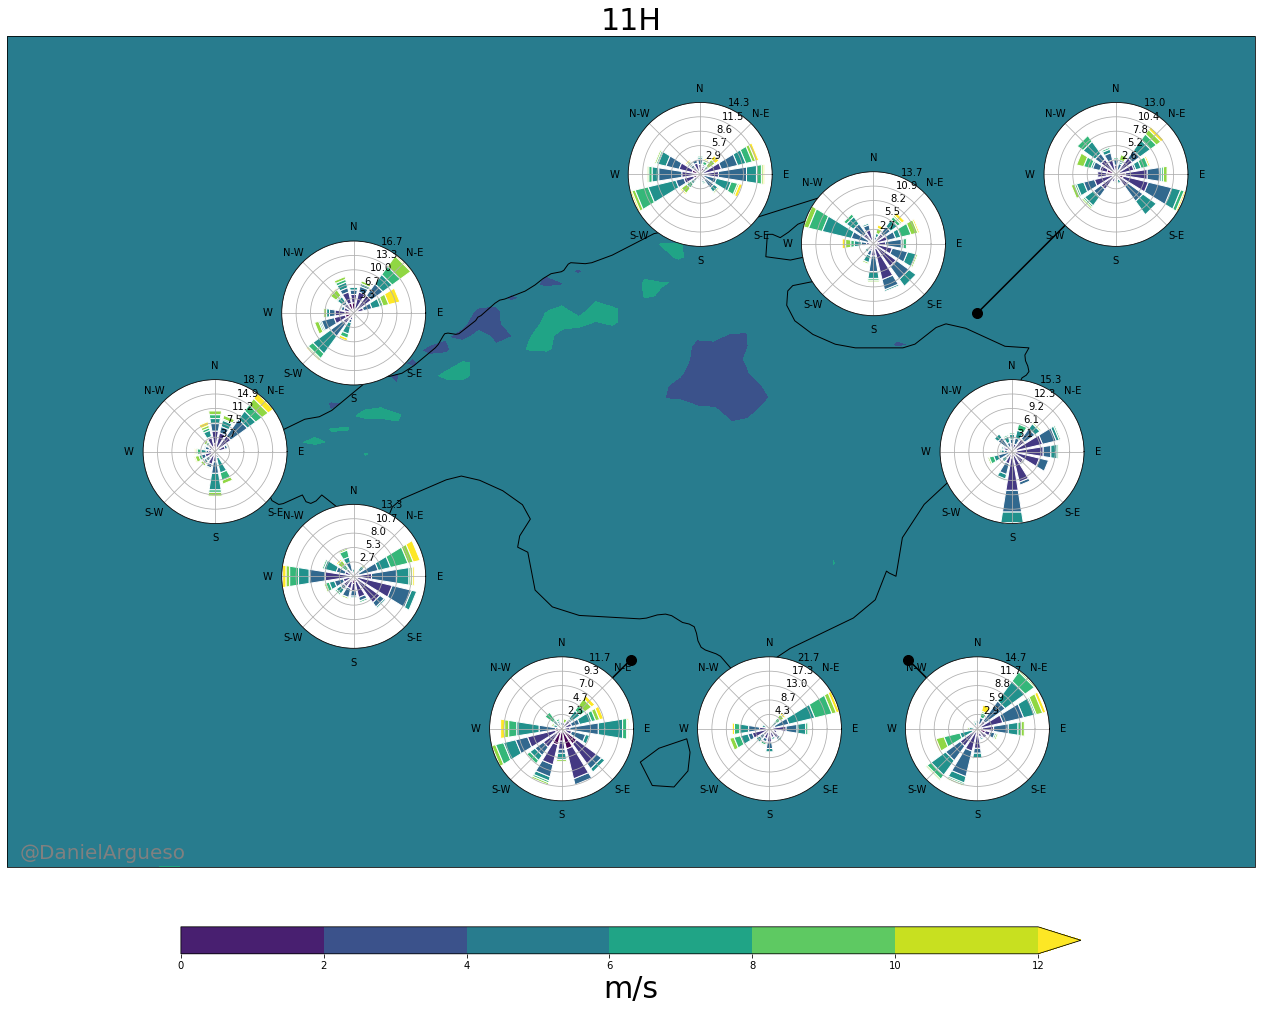

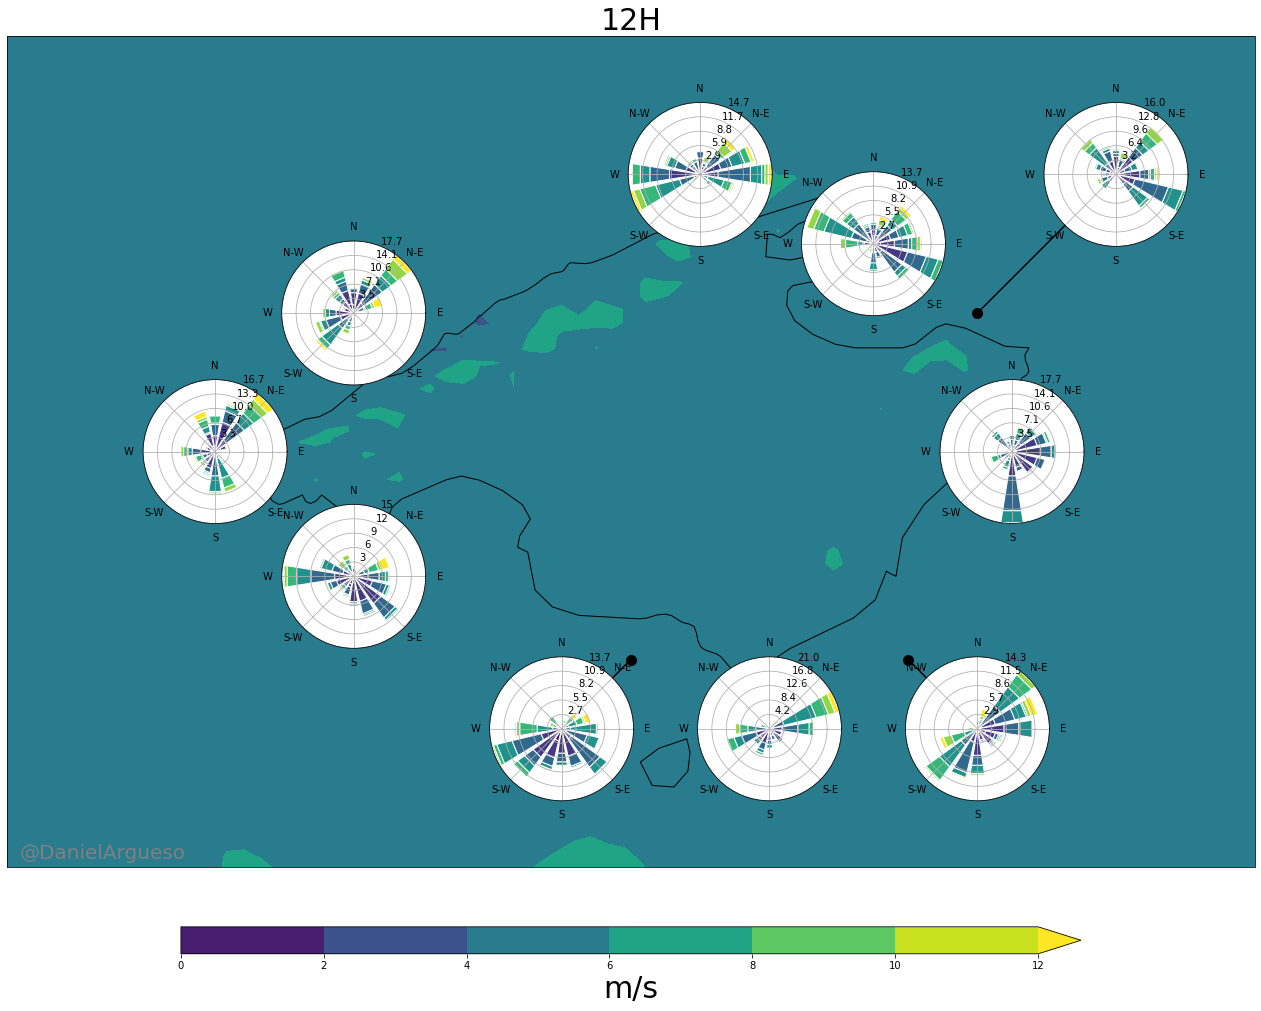

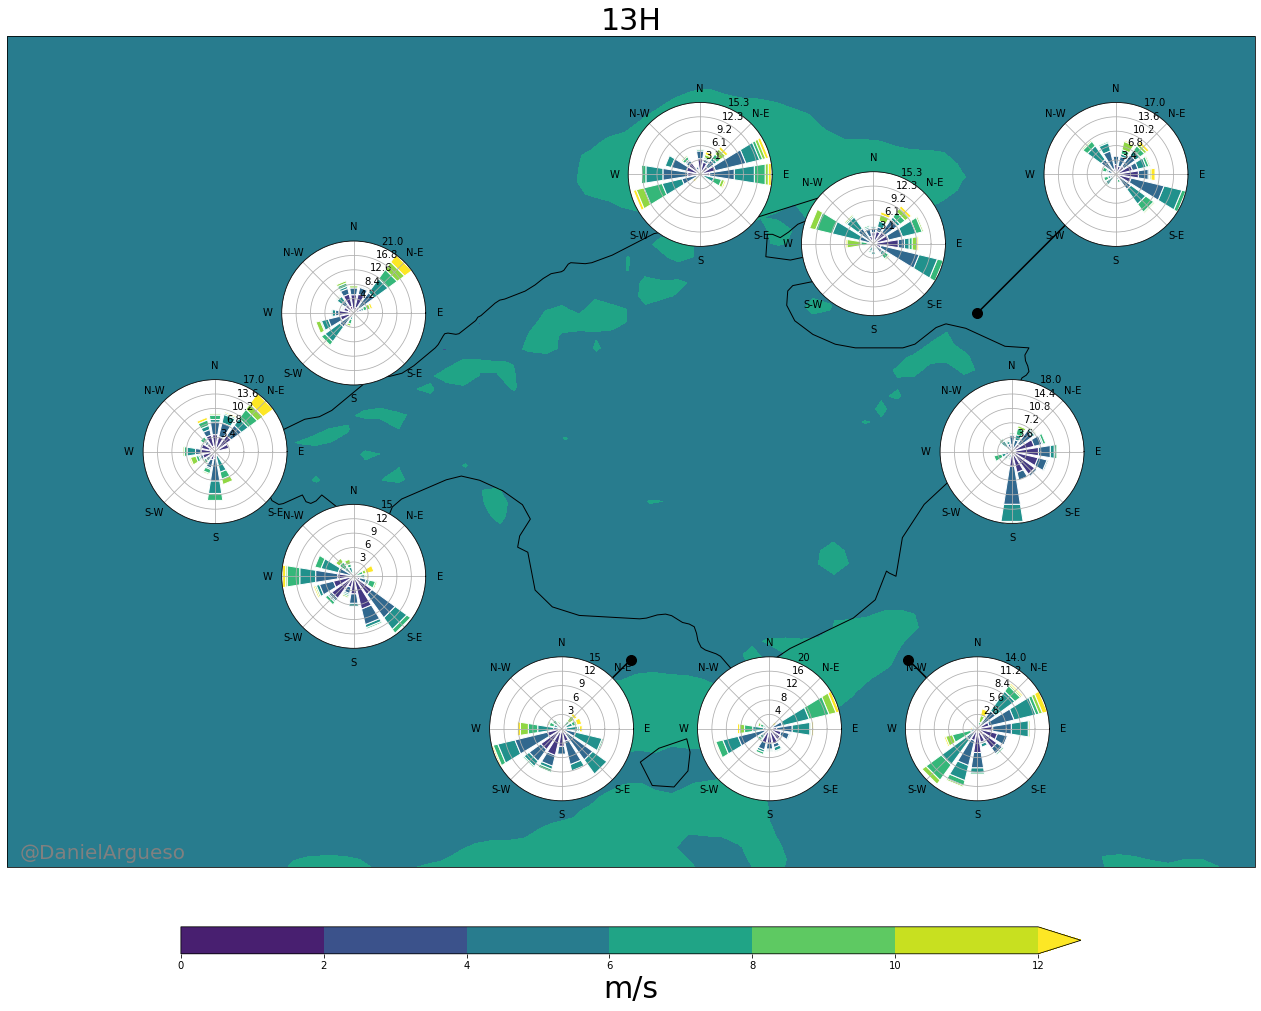

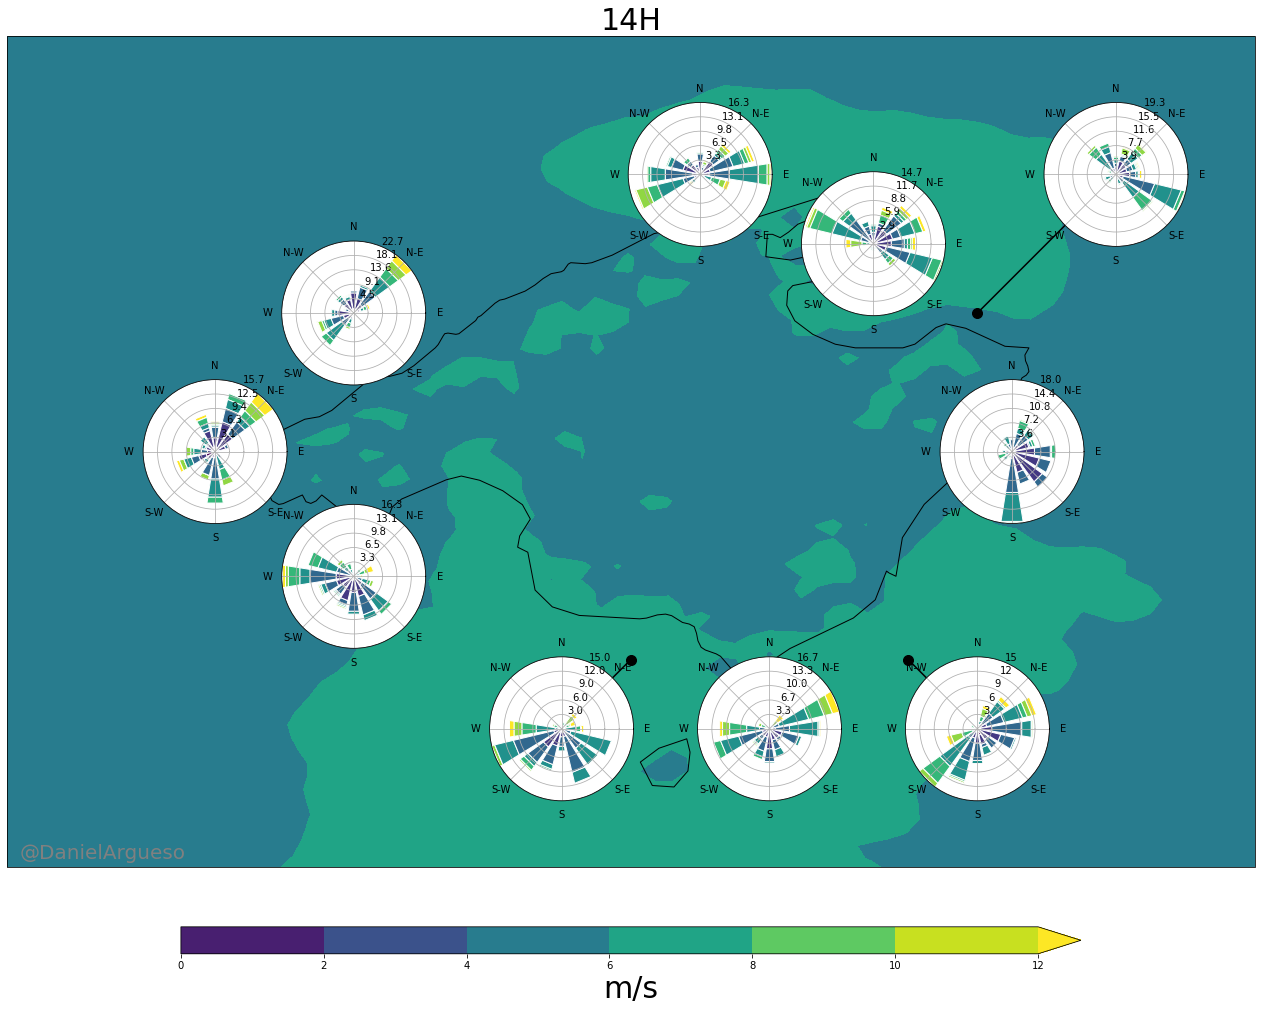

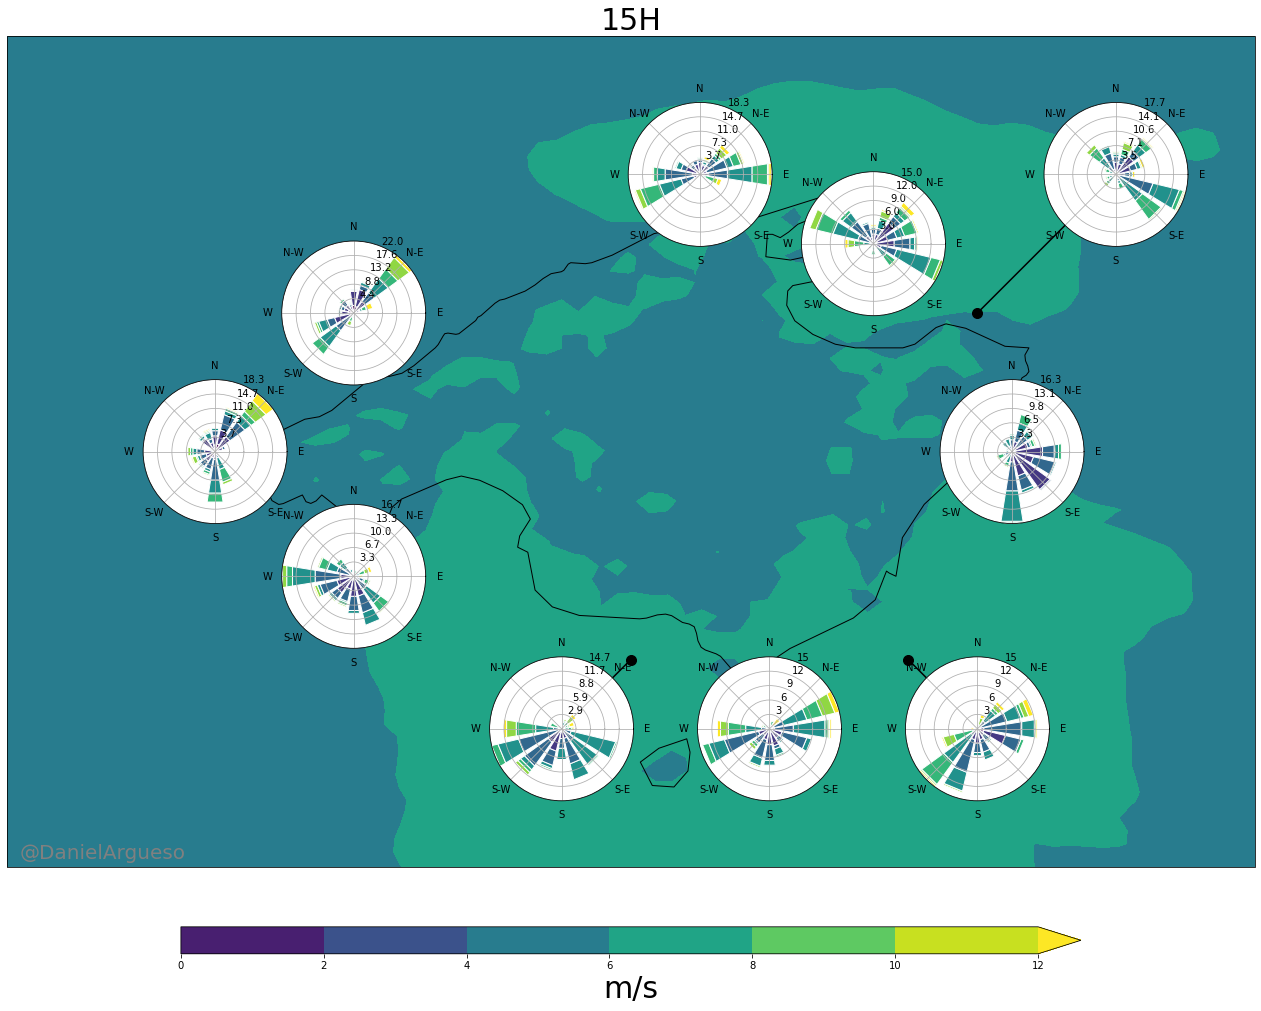

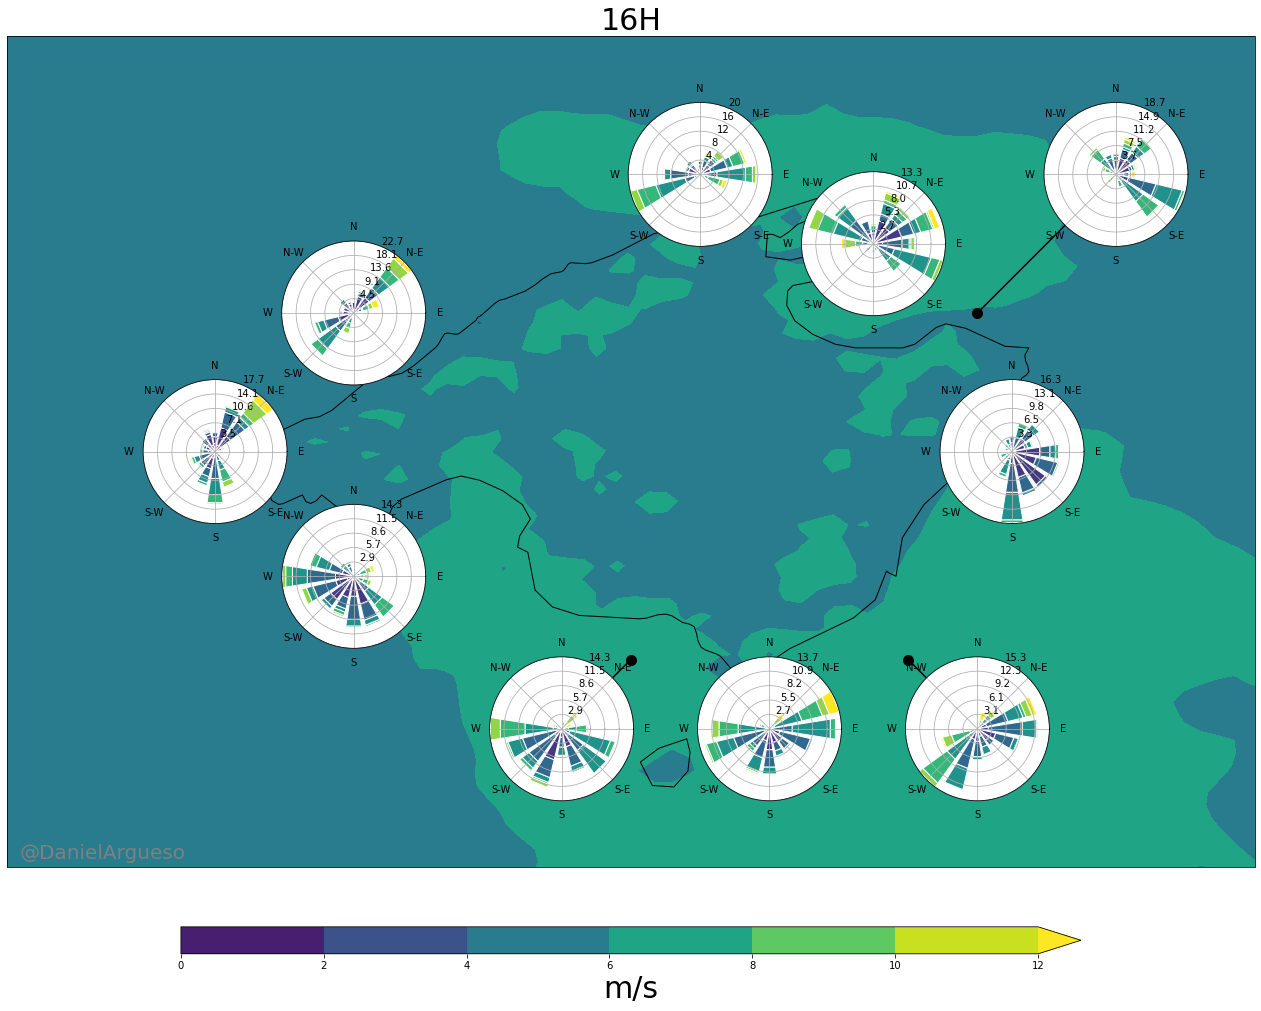

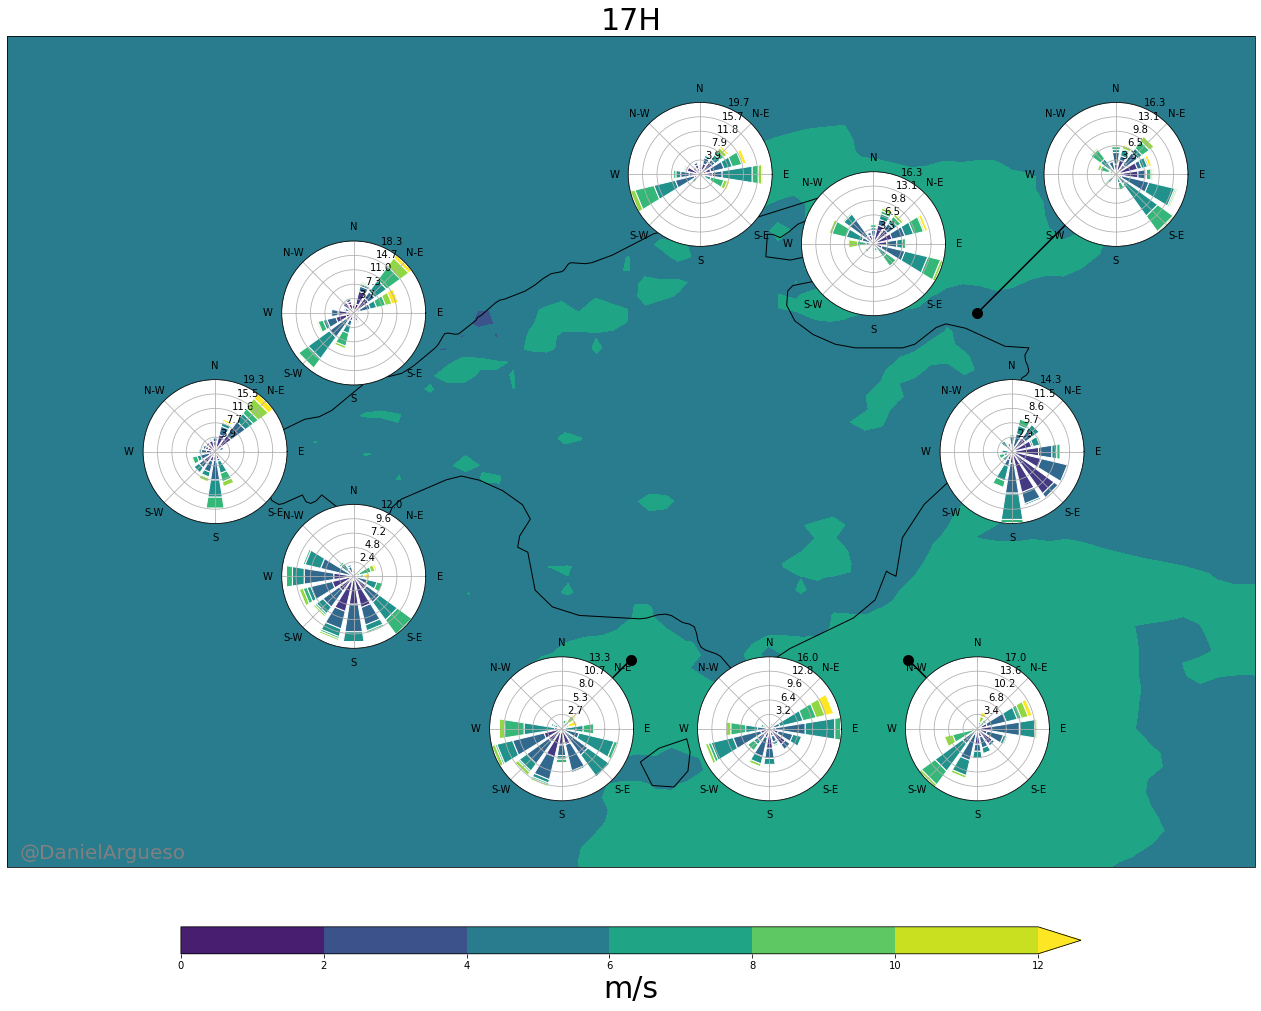

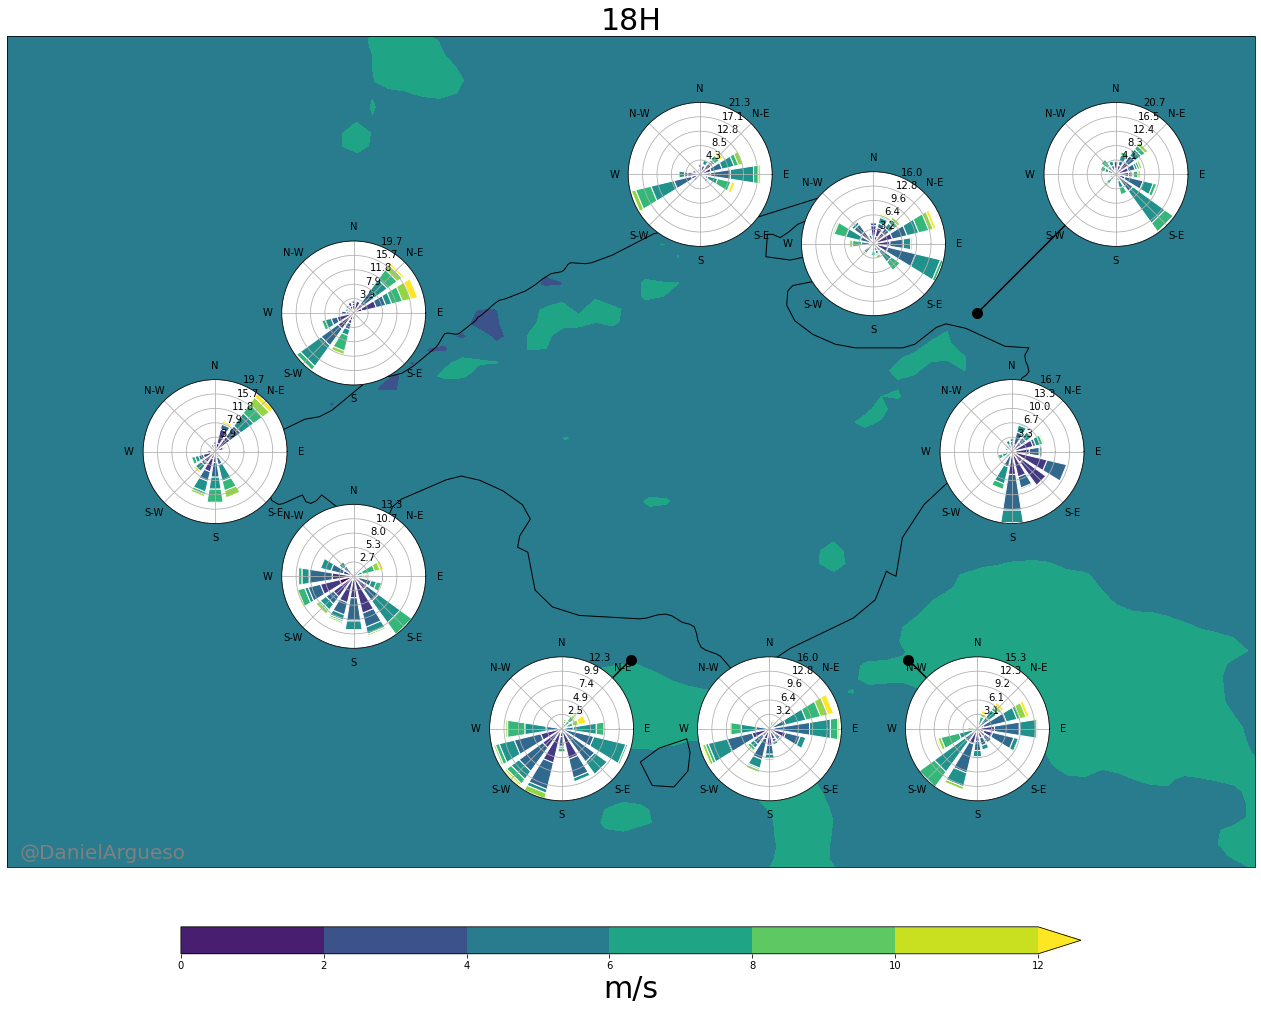

In [19]:
for hour in range(8,17):
    print (f'{hour+2:02}H')
    hour_LT = hour + 2

    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()



    loc_lat = {'1': 40,'2': 39.8,'3':39.6,'4':39.42,'5':39.3,'6':39.90,'7':39.8,'8':39.60,'9':39.3,'10':39.2}
    loc_lon = {'1':  3,'2':  2.5,'3': 2.3,'4':  2.5,'5': 2.90,'6': 3.25,'7': 3.4,'8': 3.45,'9': 3.3,'10': 3.1}


    fin_dir_h = fin_dir.where((fin_dir.time.dt.hour==hour) ,drop=True)
    fin_spd_h = fin_uv.where((fin_uv.time.dt.hour==hour),drop=True)

    m0=ax.contourf(to_np(fin_u.lon.isel(time=0).squeeze()), to_np(fin_u.lat.isel(time=0).squeeze()), fin_spd_h.mean(dim='time'),
                 transform=ccrs.PlateCarree(),
                 cmap='viridis',extend='max',levels=np.arange(0,14,2))



    ax.set_extent([2,3.8,39,40.2],crs=ccrs.PlateCarree())
    ax.text(0.01,0.01,'@DanielArgueso', fontsize='20', horizontalalignment='left', transform=ax.transAxes,c='gray')
    ax.set_title(f'{hour_LT}H',fontsize=30)


    for loc in loc_lon.keys():
    

        lon,lat = loc_lon[loc],loc_lat[loc]
    
        if loc =='5':
            lon,lat = loc_lon[loc]-0.1,loc_lat[loc]-0.1
            ax.scatter(x=loc_lon[loc], y=loc_lat[loc], s=100, c='k',zorder=101,transform=ccrs.PlateCarree())
            ax.plot(np.asarray([loc_lon[loc],loc_lon[loc]-0.1]),np.asarray([loc_lat[loc],loc_lat[loc]-0.1]), c='k',zorder=101,transform=ccrs.PlateCarree())

        if loc =='7':
            lon,lat = loc_lon[loc]+0.2,loc_lat[loc]+0.2
            ax.scatter(x=loc_lon[loc], y=loc_lat[loc], s=100, c='k',zorder=101,transform=ccrs.PlateCarree())
            ax.plot(np.asarray([loc_lon[loc],loc_lon[loc]+0.2]),np.asarray([loc_lat[loc],loc_lat[loc]+0.2]), c='k',zorder=101,transform=ccrs.PlateCarree())
    
        if loc =='9':
            lon,lat = loc_lon[loc]+0.1,loc_lat[loc]-0.1
            ax.scatter(x=loc_lon[loc], y=loc_lat[loc], s=100, c='k',zorder=101,transform=ccrs.PlateCarree())
            ax.plot(np.asarray([loc_lon[loc],loc_lon[loc]+0.1]),np.asarray([loc_lat[loc],loc_lat[loc]-0.1]), c='k',zorder=101,transform=ccrs.PlateCarree())

    
        lonr,latr =  ccrs.PlateCarree().transform_point(lon,lat, ccrs.PlateCarree())

        wrax_passy = inset_axes(ax,
            width=2,                        # size in % of bbox
            height=2,                       # size in % of bbox
            loc='center',  # don't know why, but this doesn't work.
            # specify the center lon and lat of the plot, and size in degree
            bbox_to_anchor=(lonr,latr),
            bbox_transform=ax.transData,
            axes_class=windrose.WindroseAxes
            )
        wrax_passy.bar(fin_dir_h.sel(x=loc_lon[f'{loc}'], y=loc_lat[f'{loc}'],method="nearest").values,fin_spd_h.sel(x=loc_lon[f'{loc}'], y=loc_lat[f'{loc}'],method="nearest").values,normed=True,bins=np.arange(0,14,2), opening=0.8, edgecolor='white',cmap=cm.viridis)

    cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
    cbar=plt.colorbar(m0, cax=cbar_ax,orientation="horizontal")
    cbar.set_label ('m/s',fontsize='30')
    fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.18,wspace=0.05,hspace=0.05)
    plt.savefig(f'Mallorca_Wind_April_{hour_LT:03}H.png',dpi=300)